In [1]:
# Import all necessary libraries
import torch
import random
import numpy as np
import torchvision.datasets
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [19]:
# Load MNIST train dataset
MNIST_train = torchvision.datasets.MNIST('./', download=False, train=True)
# Load MNIST test dataset
MNIST_test = torchvision.datasets.MNIST('./', download=False, train=False)

In [20]:
# Get training data
X_train = MNIST_train.data.float()
# Get training targets
y_train = MNIST_train.targets
# Get test data
X_test = MNIST_test.data.float()
# Get test targets
y_test = MNIST_test.targets

In [21]:
# Show minimum and maximum values in training data
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [22]:
X_train /= 255.
X_test /= 255.

tensor(5) tensor(0) tensor(4) tensor(1) tensor(9) tensor(2) tensor(1) tensor(3) tensor(1) tensor(4) 

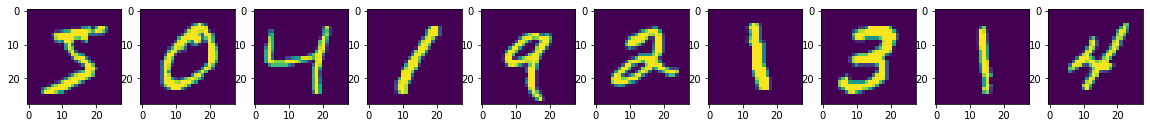

In [6]:
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [29]:
X_train.shape, y_train.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([60000]))

In [40]:
X_test.shape, y_test.shape

(torch.Size([10000, 28, 28, 1]), torch.Size([10000]))

In [45]:
X_train = X_train.reshape([-1, 1, 28, 28])
X_test = X_test.reshape([-1, 1, 28, 28])

In [54]:
class MNIST_clas(torch.nn.Module):
    def __init__(self):
        super(MNIST_clas, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding=1)
        self.batch1 = torch.nn.BatchNorm2d(6)
        self.act1 = torch.nn.ReLU()
        self.maxp1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=1)
        self.conv4 = torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.batch2 = torch.nn.BatchNorm2d(16)
        self.act2 = torch.nn.ReLU()
        self.maxp2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flat1 = torch.nn.Flatten()
        self.lin1 = torch.nn.Linear(784, 120)
        self.batch3 = torch.nn.BatchNorm1d(120)
        self.act3 = torch.nn.ReLU()

        self.lin2 = torch.nn.Linear(120, 84)
        self.batch4 = torch.nn.BatchNorm1d(84)
        self.act4 = torch.nn.ReLU()

        self.lin3 = torch.nn.Linear(84, 10)
        self.act5 = torch.nn.Softmax()
    
    def forward(self, out):
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.batch1(out)
        out = self.act1(out)
        out = self.maxp1(out)

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.batch2(out)
        out = self.act2(out)
        out = self.maxp2(out)

        out = self.flat1(out)
        out = self.lin1(out)
        out = self.batch3(out)
        out = self.act3(out)

        out = self.lin2(out)
        out = self.batch4(out)
        out = self.act4(out)

        out = self.lin3(out)
        out = self.act5(out)
        return out

In [55]:
digit_rec = MNIST_clas()

In [56]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(digit_rec.parameters(), lr=0.0005)

In [57]:
batch_size = 1024

test_accuracy_history = []
test_loss_history = []

for epoch in range(30):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        pred = digit_rec.forward(X_batch)

        loss_val = loss(pred, y_batch)
        loss_val.backward()

        optimizer.step()
    
    test_pred = digit_rec.forward(X_test)
    test_loss_history.append(loss(test_pred, y_test).data.cpu())

    accuracy = (test_pred.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    print(accuracy)

C:\Users\danii\AppData\Local\Temp\ipykernel_16480\2549431260.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.act5(out)


tensor(0.9541)
tensor(0.9801)
tensor(0.9866)
tensor(0.9882)
tensor(0.9903)
tensor(0.9898)
tensor(0.9919)
tensor(0.9918)
tensor(0.9918)
tensor(0.9919)
tensor(0.9923)
tensor(0.9930)
tensor(0.9934)
tensor(0.9930)
tensor(0.9923)
tensor(0.9929)
tensor(0.9930)
tensor(0.9933)
tensor(0.9922)
tensor(0.9935)
tensor(0.9927)
tensor(0.9933)
tensor(0.9929)
tensor(0.9928)
tensor(0.9925)
tensor(0.9931)
tensor(0.9925)
tensor(0.9929)
tensor(0.9925)
tensor(0.9931)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


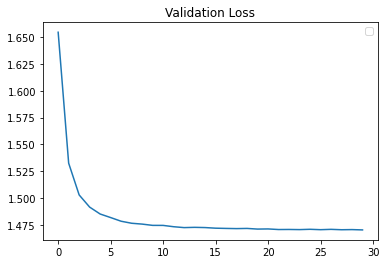

In [58]:
plt.plot(test_loss_history)
plt.legend()
plt.title('Validation Loss');

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


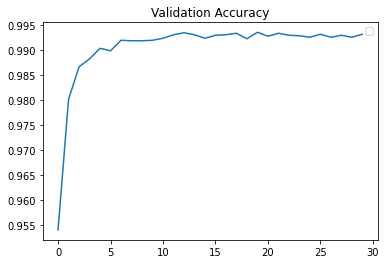

In [59]:
plt.plot(test_accuracy_history)
plt.legend()
plt.title('Validation Accuracy');

In [62]:
torch.save(digit_rec.state_dict(), 'digit_rec_cnn.pt')